In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import *
from scipy.stats import shapiro
import seaborn as sns

In [193]:
# Loading the Data
df_coe = pd.read_csv('COE.csv')
df_annual_registrations = pd.read_csv('TotalAnnualNewRegistrationByMake.csv')
df_age_distribution = pd.read_csv('AnnualAgeDistributionofCars.csv')

# A. Data Preprocessing

## 1. COE Dataset

In [194]:
df_coe.describe()

,bidding_no,quota,bids_success,premium
count,1655.000000,1636.000000,1652.000000,1652.000000
mean,1.498489,567.573961,559.896489,47582.165254
std,0.500149,429.516544,428.397597,30130.624864
min,1.000000,43.000000,39.000000,852.000000
25%,1.000000,306.750000,295.000000,28490.000000
50%,1.000000,424.000000,412.500000,47006.000000
75%,2.000000,628.000000,613.500000,66002.500000
max,2.000000,2272.000000,2246.000000,158004.000000


In [195]:
# Checking for missing values
df_coe.isnull().sum()

month             0
bidding_no        0
vehicle_class     0
quota            19
bids_success      3
bids_received     0
premium           3
dtype: int64

In [196]:
# Find all null data in the COE dataset in the quota column
df_coe[df_coe['quota'].isnull()]

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
28,2010-03,2,Category D,NaN,368.0,495,1200.0
97,2010-10,2,Category C,NaN,210.0,287,30511.0
128,2011-01,2,Category D,NaN,335.0,458,1690.0
188,2011-07,2,Category D,NaN,332.0,496,2012.0
786,2016-07,2,Category B,NaN,1463.0,2439,57508.0
814,2016-10,1,Category E,NaN,435.0,642,54200.0
843,2017-01,1,Category D,NaN,374.0,438,6053.0
907,2017-07,2,Category C,NaN,1084.0,1943,42809.0
983,2018-03,1,Category D,NaN,525.0,885,8009.0
1019,2018-06,2,Category E,NaN,580.0,868,34400.0


In [197]:
# Find all null data in the COE dataset in the quota column
df_coe[df_coe['premium'].isnull()]

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
43,2010-05,1,Category D,340.0,317.0,415,NaN
143,2011-03,1,Category D,325.0,310.0,490,NaN
1640,2023-12,1,Category A,928.0,923.0,"1,233",NaN


In [198]:
# Find all null data in the COE dataset in the bids_success column
df_coe[df_coe['bids_success'].isnull()]

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
79,2010-08,2,Category E,315.0,NaN,583,43501.0
874,2017-04,1,Category E,486.0,NaN,748,54556.0
947,2017-11,2,Category C,244.0,NaN,356,57701.0


### Deal with premium & bids_success null

In [199]:
# Add an index column to preserve the original order
df_coe['index_column'] = range(len(df_coe))

# Sort the DataFrame by vehicle class and month
sorted_df_coe = df_coe.sort_values(by=['vehicle_class', 'month'])

Considering the patterns observed in the **'premium'** column trends, similarities are noted in the changes over months for bidding number 1 and 2 within the same year and vehicle class. Hence, **nearest neighbor interpolation** is employed to address missing values.

In [200]:
# Fill missing values in the 'premium' column using nearest neighbor interpolation
sorted_df_coe['premium'].interpolate(method='linear', inplace=True)

With minimal difference observed in **'quota', 'bids_success', and 'bids_received'** values between bidding numbers 1 and 2 within the same year and vehicle class, **forward fill** is selected as the method to address missing values for 'bids_success'.

In [201]:
# Fill missing values in 'bids_success' column using forward fill method
sorted_df_coe['bids_success'].fillna(method='ffill', inplace=True)

In [202]:
# Return the DataFrame to its original order
df_coe = sorted_df_coe.sort_values(by='index_column').drop(columns='index_column')

### Deal with quota null

In [203]:
# Splitting the 'month' column to extract the 'year' and 'month1' components for intentional grouping
df_coe[['year', 'month1']] = df_coe['month'].str.split("-", expand=True)

Observing normal distribution of **'quota'** values within specific vehicle class and year, fill missing values with the **mean** of quota grouped by vehicle class and year.


In [204]:
# Group the DataFrame by 'vehicle_class' and 'year', and calculate the mean of 'quota'
grouped_means = df_coe.groupby(['vehicle_class', 'year'])['quota'].transform('mean')

# Fill missing values with the respective group mean
df_coe['quota'].fillna(grouped_means, inplace=True)

In [205]:
# Drop the 'year' and 'month1' columns from the DataFrame
df_coe.drop(['year', 'month1'], axis=1, inplace=True)

### Check and proceed with other steps

In [206]:
# Verify that there are no remaining null values in the DataFrame 
df_coe.isnull().sum()

month            0
bidding_no       0
vehicle_class    0
quota            0
bids_success     0
bids_received    0
premium          0
dtype: int64

In [207]:
## Convert 'month' to datetime format
df_coe['month'] = pd.to_datetime(df_coe['month'], format='%Y-%m')
## Ensure numerical columns are of correct data type
df_coe['quota'] = pd.to_numeric(df_coe['quota'], errors='coerce')
df_coe['bids_success'] = pd.to_numeric(df_coe['bids_success'], errors='coerce')
df_coe['bids_received'] = pd.to_numeric(df_coe['bids_received'], errors='coerce')

## 2. Age Distribution Dataset

In [208]:
df_age_distribution.describe()

,year,number
count,273.000000,273.000000
mean,2016.000000,29473.124542
std,3.748529,34116.937827
min,2010.000000,128.000000
25%,2013.000000,567.000000
50%,2016.000000,19621.000000
75%,2019.000000,44185.000000
max,2022.000000,115583.000000


In [209]:
df_age_distribution.isnull().sum()

year        0
age_year    0
number      0
dtype: int64

In [210]:
## Ensure 'year' and 'number' is an integer
df_age_distribution['year'] = df_age_distribution['year'].astype(int)
df_age_distribution['number'] = df_age_distribution['number'].astype(int)

## 3. Annual New Registration Dataset

In [211]:
df_annual_registrations.describe()

,year,number
count,784.000000,657.000000
mean,2016.820153,1004.659056
std,3.711781,2362.489157
min,2010.000000,1.000000
25%,2014.000000,14.000000
50%,2018.000000,111.000000
75%,2020.000000,645.000000
max,2022.000000,19349.000000


In [212]:
# Checking for missing values
df_annual_registrations.isnull().sum()

year        0
make        0
number    127
dtype: int64

In [213]:
# Find all unique data in the 'make' column
df_annual_registrations['make'].unique(), len(df_annual_registrations['make'].unique())

(array(['ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'B.M.W.', 'BENTLEY', 'CHERY',
        'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAIHATSU', 'DODGE',
        'DONGFENG', 'FERRARI', 'FIAT', 'FORD', 'GEELY', 'HAFEI', 'HONDA',
        'HUMMER', 'HYUNDAI', 'JAGUAR', 'JEEP', 'KIA', 'LAMBORGHINI',
        'LAND ROVER', 'LOTUS', 'MASERATI', 'MAZDA', 'MERCEDES BENZ',
        'MINI', 'MITSUBISHI', 'MITSUOKA', 'NISSAN', 'OPEL', 'OTHERS',
        'PERODUA', 'PEUGEOT', 'PORSCHE', 'PROTON', 'RENAULT',
        'ROLLS ROYCE', 'SAAB', 'SKODA', 'SSANGYONG', 'SUBARU', 'SUZUKI',
        'TOYOTA', 'VOLKSWAGEN', 'VOLVO', 'ZOTYE', 'INFINITI', 'FOTON',
        'MCLAREN', 'ALPINA', 'AUSTIN', 'HOLDEN', 'M.G.', 'MORGAN', 'RUF',
        'TRIUMPH', 'DAIMLER', 'MORRIS', 'RANGE ROVER', 'ROVER',
        'THE LONDON TAXI CO', 'TOYO ACE', 'BYD', 'KOENIGSEGG', 'SEAT',
        'TESLA', 'BLUECAR', 'DATSUN', 'LANCIA', 'MARCOS', 'PAGANI',
        'RAMBLER', 'CHANA', 'GOLDEN DRAGON', 'MAXUS', 'NAZA', 'SMART',
        'WULING', 'ALPI

In [214]:
# Find all null data in the number column according to year
year_null = df_annual_registrations[df_annual_registrations['number'].isnull()]['year'].unique()
year_null

array([2018, 2019, 2020, 2021, 2022], dtype=int64)

In [215]:
for year in year_null:
    print('Number of missing values in year', year, ':', df_annual_registrations.loc[df_annual_registrations['year'] == year]['number'].isnull().sum())

Number of missing values in year 2018 : 30
Number of missing values in year 2019 : 28
Number of missing values in year 2020 : 27
Number of missing values in year 2021 : 23
Number of missing values in year 2022 : 19


In [216]:
normality_results = []

# Loop through each unique year
for year in year_null:
    # Filter the DataFrame for the current year and select the "number" column
    number_data = df_annual_registrations.loc[df_annual_registrations['year'] == year, 'number']
    
    # Drop missing values (NaNs) from the selected column
    number_data_cleaned = number_data.dropna()
    
    # Statistical test: Shapiro-Wilk test
    stat, p = shapiro(number_data_cleaned)
    alpha = 0.05
    
    # Conclusion based on normality test result
    if p > alpha:
        print(f'Number of Registrations in {year} is normally distributed (p-value={p})')
        normality_results.append(True)
    else:
        print(f'Number of Registrations in {year} is not normally distributed (p-value={p})')
        normality_results.append(False)
        
# Decision making process based on normality test results
if all(normality_results):
    print("All years with missing values are normally distributed. Fill missing values with mean.")
else:
    print("At least one year with missing values is not normally distributed. Fill missing values with median.")

Number of Registrations in 2018 is not normally distributed (p-value=2.0886964033350885e-11)
Number of Registrations in 2019 is not normally distributed (p-value=4.686356771393951e-12)
Number of Registrations in 2020 is not normally distributed (p-value=8.490940589522822e-12)
Number of Registrations in 2021 is not normally distributed (p-value=1.0109596319807235e-11)
Number of Registrations in 2022 is not normally distributed (p-value=4.0836450432117644e-13)
At least one year with missing values is not normally distributed. Fill missing values with median.


In [217]:
# Group by year and calculate the median for years with missing data
yearly_median_null = df_annual_registrations[df_annual_registrations['year'].isin(year_null)].groupby('year')['number'].median()

# Fill missing values with the respective year's median
for year in yearly_median_null.index:
    df_annual_registrations.loc[(df_annual_registrations['year'] == year) & (df_annual_registrations['number'].isnull()), 'number'] = yearly_median_null[year]

### Check and proceed with other steps

In [218]:
df_annual_registrations.isnull().sum()

year      0
make      0
number    0
dtype: int64

In [219]:
## Ensure 'year' and 'number' is an integer
df_annual_registrations['year'] = df_annual_registrations['year'].astype(int)

In [220]:
# Remove duplicates (if any)
df_annual_registrations.drop_duplicates(inplace=True)

# B. Data Storytelling

In [221]:
def format_plot():
    """Format the plot by hiding gridlines and adding thicker black border lines."""
    # Hiding gridlines
    plt.grid(False)

    # Adding thicker black border line
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_color('black')

## 1. Bids Received & Premium & Quota

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13388\1406303328.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_filtered, x='year', y='bids_received', hue='vehicle_class', palette='bright', ci=None, linewidth=2.5)


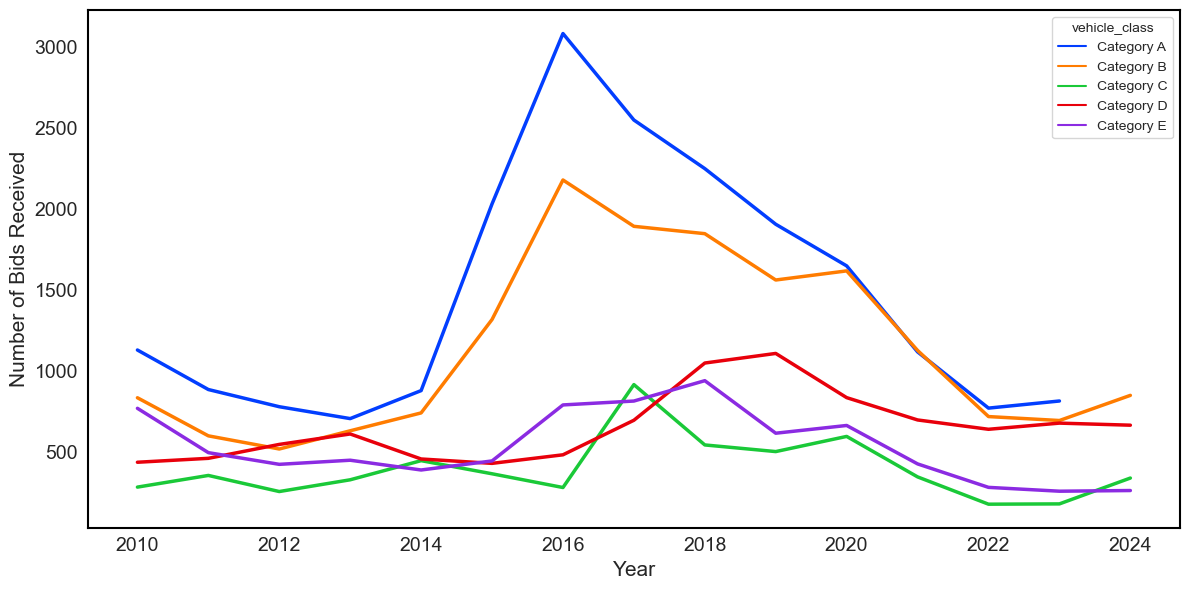

In [222]:
# Convert 'month' column to datetime type
df_coe['month'] = pd.to_datetime(df_coe['month'])

# Extract year from 'month' column
df_coe['year'] = df_coe['month'].dt.year

# Filter dataframe to include only years where all categories have data
valid_years = df_coe.groupby('year')['vehicle_class'].nunique()
valid_years = valid_years[valid_years == df_coe['vehicle_class'].nunique()].index
df_filtered = df_coe[df_coe['year'].isin(valid_years)]

# Plotting demand changing over time with Seaborn for different categories
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_filtered, x='year', y='bids_received', hue='vehicle_class', palette='bright', ci=None, linewidth=2.5)

# Applying formatting
format_plot() 

plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of Bids Received', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Save the plot as a picture
plt.savefig('demand_change_over_time.png')

# Show the plot
plt.show()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13388\2179500880.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_filtered_premium, x='year', y='premium', hue='vehicle_class', palette='bright', ci=None, linewidth=2.5)


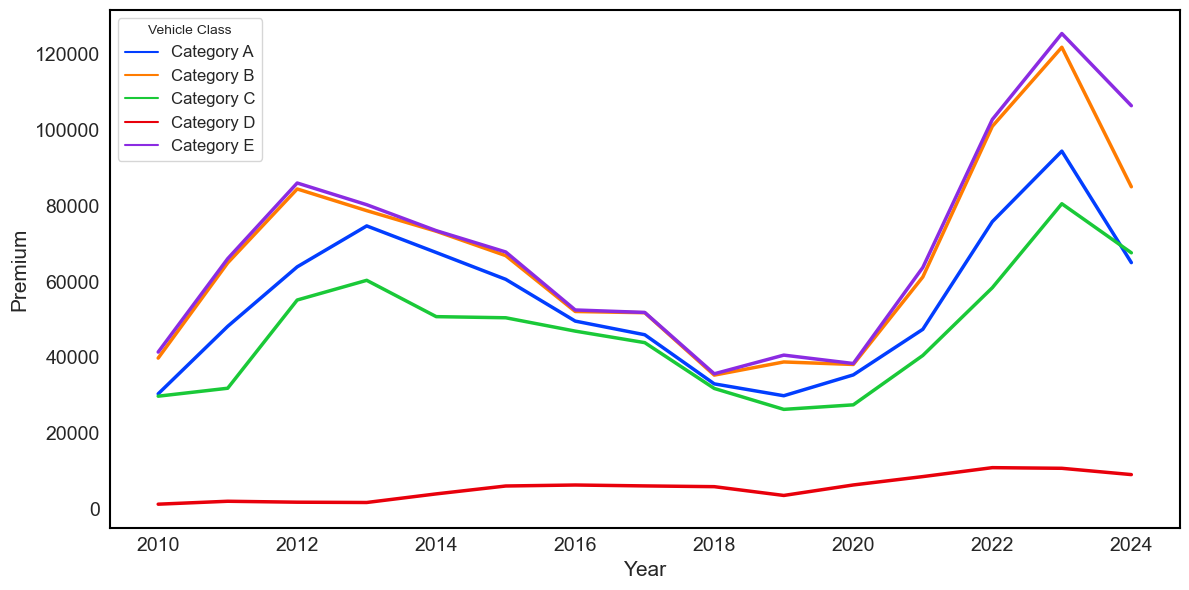

In [223]:
# Filter dataframe to include only years where all categories have data
valid_years_premium = df_coe.groupby('year')['vehicle_class'].nunique()
valid_years_premium = valid_years_premium[valid_years_premium == df_coe['vehicle_class'].nunique()].index
df_filtered_premium = df_coe[df_coe['year'].isin(valid_years_premium)]

# Plotting premium changing over time with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_filtered_premium, x='year', y='premium', hue='vehicle_class', palette='bright', ci=None, linewidth=2.5)

# Applying formatting
format_plot() 

plt.xlabel('Year', fontsize=15)
plt.ylabel('Premium', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Adjusting legend position
plt.legend(title='Vehicle Class', loc='upper left', fontsize=12)

# Save the plot as a picture
plt.savefig('premium_change_over_time_year.png')

# Show the plot
plt.show()


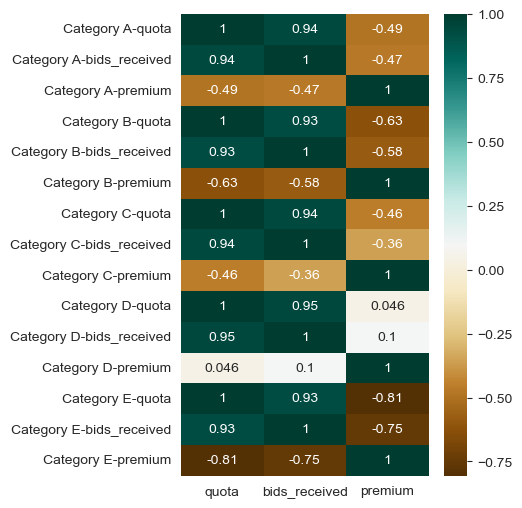

In [224]:
# Calculate correlation between 'bids_received' and 'premium' for each vehicle class
correlation_data = df_coe.groupby('vehicle_class')[['quota','bids_received', 'premium']].corr()

# Correlation heatmap
plt.figure(figsize=(4, 6))
sns.heatmap(correlation_data, annot=True, cmap='BrBG')
plt.ylabel('')

# Save the heatmap as a new image
plt.savefig('correlation_3_vars.png', bbox_inches='tight')

plt.show()

### Adjust Premium using GDP per Capita

In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load COE data
df_coe = pd.read_csv('COE.csv')

# Convert 'month' column to datetime format
df_coe['month'] = pd.to_datetime(df_coe['month'])

# Extract 'year' from the 'month' column
df_coe['year'] = df_coe['month'].dt.year

# Load GDP per capita data
df_gdp = pd.read_csv("GDP_per_capita.csv")

# Merge COE data with GDP per capita data based on the 'year' column
merged_df = pd.merge(df_coe, df_gdp, on='year', how='left')

# Calculate the ratio of COE premium to GDP per capita
merged_df['premium_to_gdp_ratio'] = merged_df['premium'] / merged_df['gdp_per_capita']

In [226]:
# Calculate adjustment factor for each period
merged_df['adjustment_factor'] = merged_df['premium'] / merged_df['gdp_per_capita']

# Calculate adjusted COE price
merged_df['adjusted_coe_price'] = merged_df['premium'] * merged_df['adjustment_factor']

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13388\2556117447.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_filtered, x='year', y='adjusted_coe_price', hue='vehicle_class', palette='bright', ci=None, linewidth=2.5)


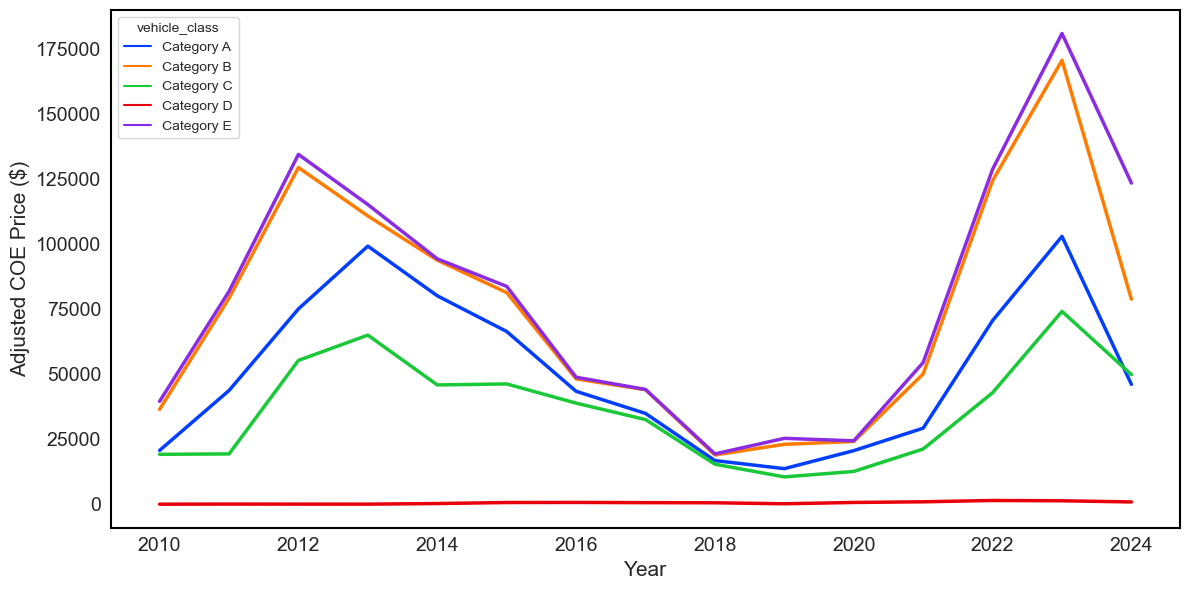

In [227]:
# Filter dataframe to include only years where all categories have data
valid_years = merged_df.groupby('year')['vehicle_class'].nunique()
valid_years = valid_years[valid_years == merged_df['vehicle_class'].nunique()].index
df_filtered = merged_df[merged_df['year'].isin(valid_years)]

# Plotting adjusted COE price over time with Seaborn for different categories
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_filtered, x='year', y='adjusted_coe_price', hue='vehicle_class', palette='bright', ci=None, linewidth=2.5)

# Applying formatting
plt.xlabel('Year', fontsize=15)
plt.ylabel('Adjusted COE Price ($)', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

# Applying formatting
format_plot() 

# Save the plot as a picture
plt.savefig('adjusted_coe_price_using_gdp_per_capita_by_year.png')

# Show the plot
plt.show()

## 2. Improvement of Public Transport

### a. Number of stations

In [228]:
Number_of_stations = pd.read_csv('NumberofMRTandLRTStations.csv')

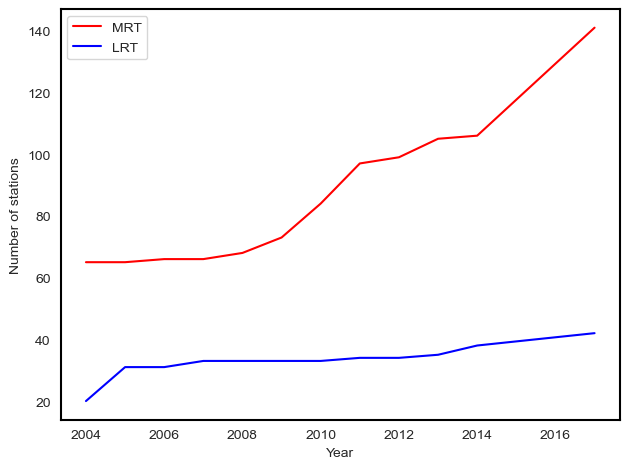

In [229]:
#Plot the number of stations for MRT and LRT respectively over the years
Number_of_stations.plot.line(x = 'year',y = ['mrt','lrt'], color = ['red','blue'])

#Labels
plt.xlabel('Year')
plt.ylabel('Number of stations')
plt.legend(labels=['MRT', 'LRT'])
plt.tight_layout()

# Applying formatting
format_plot() 

# Save the plot as a picture
plt.savefig('no_of_stations.png')

# Show the plot
plt.show()

### b.  Number of bus routes

In [230]:
Number_of_bus_routes = pd.read_csv('PublicTransportCapacityBusRoutesinOperation.csv')

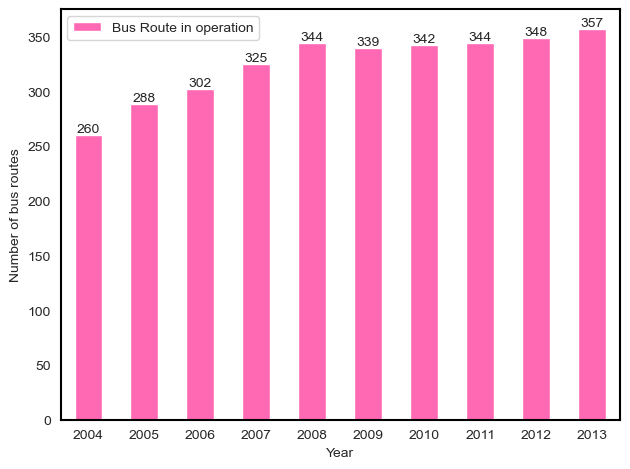

In [236]:
#Plot the number of bus route in operation over the years
Number_of_bus_routes.plot.bar(x = 'year',y = ['bus_route_in_operation'], color = ['hotpink'],rot = 0)

# Add bar labels
for index, value in enumerate(Number_of_bus_routes['bus_route_in_operation']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.xlabel('Year')
plt.ylabel('Number of bus routes')
plt.legend(labels=['Bus Route in operation'])
plt.tight_layout()

# Applying formatting
format_plot() 

# Save the plot as a picture
plt.savefig('no_of_bus_route.png')

# Show the plot
plt.show()

### c. Yearly rail length

In [232]:
yearly_rail_length = pd.read_csv('yearly_rail_length.csv')

<Figure size 3000x1000 with 0 Axes>

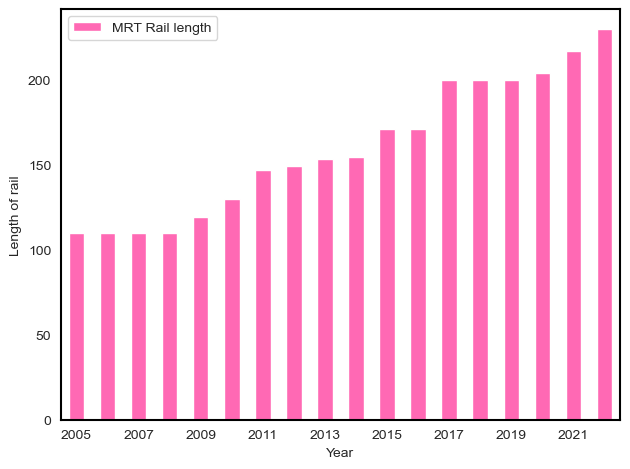

In [233]:
#Filter mrt rail type and plot rail length over the years
mrt_lengths = yearly_rail_length[yearly_rail_length['rail_type'] == 'mrt']

plt.figure(figsize=(30, 10))
mrt_lengths.plot.bar(x='year', y='length', color='hotpink', rot=0)

# Set the tick positions and labels for the x-axis - display every 2 years
tick_positions = np.arange(0, len(mrt_lengths), 2)
tick_labels = mrt_lengths['year'][::2]  # Display every 2nd year

plt.xticks(tick_positions, tick_labels)

plt.xlabel('Year')
plt.ylabel('Length of rail')
plt.legend(labels=['MRT Rail length'])
plt.tight_layout()

# Applying formatting
format_plot() 

# Save the plot as a picture
plt.savefig('mrt_rail_length.png')

# Show the plot
plt.show()

### d. Average trip distance

In [234]:
Average_Trip_Distance = pd.read_csv('PublicTransportUtilisationAverageTripDistance.csv')

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_13388\1855154863.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=each_mode_filtered, x='year', y='ave_distance_per_trip', hue='mode', palette='bright', ci=None, linewidth=2.5)


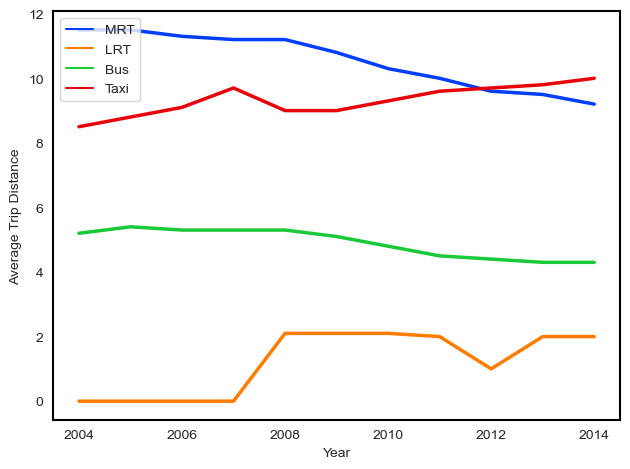

In [235]:
#Categorise each mode: MRT, LRT, Bus, Taxi and plot the average trip distance respectively

each_mode = Average_Trip_Distance.groupby('year')['mode'].nunique()
each_mode = each_mode[each_mode == Average_Trip_Distance['mode'].nunique()].index
each_mode_filtered = Average_Trip_Distance[Average_Trip_Distance['year'].isin(each_mode)]

plt.xlabel('Year')
plt.ylabel('Average Trip Distance')
sns.lineplot(data=each_mode_filtered, x='year', y='ave_distance_per_trip', hue='mode', palette='bright', ci=None, linewidth=2.5)
plt.legend(loc='upper left')
plt.tight_layout()

# Applying formatting
format_plot() 

# Save the plot as a picture
plt.savefig('avg_trip_distance.png')

# Show the plot
plt.show()